In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import requests
from matplotlib.backends.backend_pdf import PdfPages

## read in the daily values for the entire history of Lee's Ferry and the Grand Canyon

In [2]:
# Ohh interesting - use += to concatonate strings too!
site_num = {'Lees Ferry':'09380000',"Grand Canyon": '09402500'}
urls = dict()
for ckey,cval in site_num.items():
    dv_url = 'http://waterservices.usgs.gov/nwis/dv/?format=rdb'
    dv_url += '&sites={0}'.format(cval)
    #dv_url += '&startDT=2010-01-01'
    dv_url += '&startDT=1880-01-01'
    #dv_url += '&endDT=2018-01-17'
    dv_url += '&parameterCd=00060'
    print(dv_url)
    urls[ckey] = dv_url

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060
http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09402500&startDT=1880-01-01&parameterCd=00060


In [3]:
urls

{'Lees Ferry': 'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060',
 'Grand Canyon': 'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09402500&startDT=1880-01-01&parameterCd=00060'}

In [4]:

for ckey,cval in urls.items():
    print ('reading data for {0}'.format(ckey))
    dv_file = requests.get(cval)

    with open(os.path.join('data','pandas','{0}.dat'.format(ckey)), 'w') as ofp:
        for carp in dv_file:
            ofp.write(carp.decode())

reading data for Lees Ferry
reading data for Grand Canyon


In [5]:
NWISfilename = os.path.join('data','pandas','Lees Ferry.dat')
reconnoiter = open(NWISfilename, 'r').readlines()
for i in np.arange(60):
    print (reconnoiter[i].rstrip())

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database may not
# have received Director's approval.  Any such data values are qualified as provisional and
# are subject to revision.  Provisional data are released on the condition that neither the
# USGS nor the United States Government may be held liable for any damages resulting from its use.
#  Go to http://help.waterdata.usgs.gov/policies/provisional-data-statement for more information.
#
# File-format description:  http://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: http://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2019-11-20 12:19:21 -05:00	(natwebsdas01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 09380000 COLORADO RIVER AT LEES FERRY, AZ
# -----------------------------------------------

In [6]:
numhash = 0 #let's use the as the counter
for line in reconnoiter:
    if line.startswith('#'):
        numhash +=1
    else:
        break
        
print (numhash)

30


# Read in the time series

In [7]:
df_dict = dict()

In [8]:
for ckey in site_num.keys():
    recon = open(os.path.join('data','pandas','{0}.dat'.format(ckey))).readlines()
    numhash = 0 #let's use the as the counter
    for line in recon:
        if line.startswith('#'):
            numhash +=1
        else:
            break

    print (numhash)
    colnames = recon[numhash].rstrip().split()
    colnames[3] = 'Q'
    
    df_dict[ckey] = pd.read_csv(os.path.join('data','pandas','{0}.dat'.format(ckey)),
                          sep='\t',
                          skiprows = numhash+2,
                          names = colnames,
                          parse_dates = True,
                          index_col = 2)

30
29


In [9]:
df_dict

{'Lees Ferry':            agency_cd  site_no      Q 236239_00060_00003_cd
 datetime                                                  
 1921-10-01      USGS  9380000   7120                     A
 1921-10-02      USGS  9380000  11800                     A
 1921-10-03      USGS  9380000   7830                     A
 1921-10-04      USGS  9380000   7470                     A
 1921-10-05      USGS  9380000   6780                     A
 ...              ...      ...    ...                   ...
 2019-11-15      USGS  9380000  10800                     P
 2019-11-16      USGS  9380000   9650                     P
 2019-11-17      USGS  9380000   9450                     P
 2019-11-18      USGS  9380000  10800                     P
 2019-11-19      USGS  9380000  11000                     P
 
 [35844 rows x 4 columns],
 'Grand Canyon':            agency_cd  site_no      Q 5323_00060_00003_cd
 datetime                                                
 1922-10-01      USGS  9402500   5200        

In [10]:
df_dict['Grand Canyon'].columns

Index(['agency_cd', 'site_no', 'Q', '5323_00060_00003_cd'], dtype='object')

## let's drop all the columns we don't need 
## NB --> what's up with `inplace=True`?

In [11]:
for ckey, nwis_df in df_dict.items(): 
    nwis_df.drop((['site_no']),axis=1,inplace=True)

    # we can use a list comprehension
    nwis_df.drop([i for i in nwis_df.columns if i.endswith('cd')], axis=1, inplace=True)

In [12]:
df_dict['Lees Ferry']

,Q
datetime,
1921-10-01,7120
1921-10-02,11800
1921-10-03,7830
1921-10-04,7470
1921-10-05,6780
...,...
2019-11-15,10800
2019-11-16,9650
2019-11-17,9450


## Let's look at things by water year
First, we can make a couple new columns, one for year, and one for water year.

How can we group by water year? Not a very easy Google Kung Fu exercise at first, but what about "Fiscal Year"?
Google "Pandas group by fiscal year"
http://stackoverflow.com/questions/26341272/using-groupby-on-pandas-dataframe-to-group-by-financial-year

In [13]:
# explicit is better than implicit - better to write 30+31+31 vs. +92
for ckey, nwis_df in df_dict.items(): 
    #make water year by shifting forward the number of days in Oct., Nov., and Dec.
    # NOTE --> shifting by months is less precise
    nwis_df['water_year'] = nwis_df.index.shift(30+31+31,freq='d').year


## So now we can add columns with some unit conversions

## units are $\frac{ft^3}{s}$

## So let's convert to cubic feet per day which we can later sum up by water year
## $\frac{1 ft^3}{s} \times \frac{60s}{min} \times \frac{60min}{hour} \times \frac{24hours}{day} \rightarrow \frac{ft^3}{day}$

## 1 acre-foot = 43559.9 cubic feet

In [14]:
for ckey, nwis_df in df_dict.items(): 
    nwis_df['Q_cfd'] = nwis_df.Q * 60 * 60 * 24
    nwis_df['Q_af'] = nwis_df.Q_cfd / 43559.9

In [15]:
df_dict['Lees Ferry'].head()

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1921-10-01,7120,1922,615168000,14122.346470
1921-10-02,11800,1922,1019520000,23405.012408
1921-10-03,7830,1922,676512000,15530.614166
1921-10-04,7470,1922,645408000,14816.562940
1921-10-05,6780,1922,585792000,13447.964757


In [16]:
nwis_df.head()

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1922-10-01,5200,1923,449280000,10314.073265
1922-10-02,5200,1923,449280000,10314.073265
1922-10-03,5200,1923,449280000,10314.073265
1922-10-04,5200,1923,449280000,10314.073265
1922-10-05,5200,1923,449280000,10314.073265


## `agg` is for aggregate - very powerful!

In [17]:
wateryears = dict()
for ckey, nwis_df in df_dict.items(): 

    wateryears[ckey] = nwis_df.groupby('water_year').agg(['count','mean','sum'])


In [18]:
wateryears['Lees Ferry'].columns

MultiIndex([(    'Q', 'count'),
            (    'Q',  'mean'),
            (    'Q',   'sum'),
            ('Q_cfd', 'count'),
            ('Q_cfd',  'mean'),
            ('Q_cfd',   'sum'),
            ( 'Q_af', 'count'),
            ( 'Q_af',  'mean'),
            ( 'Q_af',   'sum')],
           )

In [19]:
wateryears['Lees Ferry'].head()

Q                        Q_cfd                              \
           count          mean      sum count          mean           sum   
water_year                                                                  
1922         365  22481.123288  8205610   365  1.942369e+09  708964704000   
1923         365  22427.561644  8186060   365  1.937741e+09  707275584000   
1924         366  17166.092896  6282790   366  1.483150e+09  542833056000   
1925         365  15625.287671  5703230   365  1.350025e+09  492759072000   
1926         365  19304.876712  7046280   365  1.667941e+09  608798592000   

            Q_af                              
           count          mean           sum  
water_year                                    
1922         365  44590.760127  1.627563e+07  
1923         365  44484.521912  1.623685e+07  
1924         366  34048.526884  1.246176e+07  
1925         365  30992.377273  1.131222e+07  
1926         365  38290.752457  1.397612e+07

## Let's explore Lee's Ferry in a bit more detail

## First, any missing data?

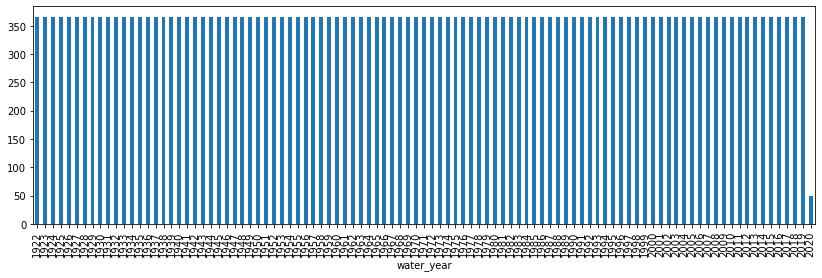

In [20]:
# Note this has a multiple index
plt.figure(figsize=(14,4))
wateryears['Lees Ferry']['Q','count'].plot(kind='bar')


## let's look at statistics to see if there are any missing days prior to 2018 (partial year)?

In [21]:
df_dict['Lees Ferry'].describe()

,Q,water_year,Q_cfd,Q_af
count,35844.000000,35844.000000,3.584400e+04,35844.000000
mean,14624.205390,1970.568714,1.263531e+09,29006.754967
std,13541.842892,28.329260,1.170015e+09,26859.915332
min,700.000000,1922.000000,6.048000e+07,1388.432939
25%,7427.500000,1946.000000,6.417360e+08,14732.265226
50%,11100.000000,1971.000000,9.590400e+08,22016.579469
75%,15700.000000,1995.000000,1.356480e+09,31140.567357
max,124000.000000,2020.000000,1.071360e+10,245950.977849


In [22]:
# Look at the mean (row) count (col) for each parameter - should have 365.25 for #days/year (averaging in leap years)
wateryears['Lees Ferry'].loc[wateryears['Lees Ferry'].index<2019].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   97.000000     97.000000  9.700000e+01   97.000000  9.700000e+01   
mean   365.247423  14649.233030  5.350635e+06  365.247423  1.265694e+09   
std      0.433756   5004.747315  1.828202e+06    0.433756  4.324102e+08   
min    365.000000   3324.584699  1.216798e+06  365.000000  2.872441e+08   
25%    365.000000  11470.684932  4.186800e+06  365.000000  9.910672e+08   
50%    365.000000  12649.315068  4.629540e+06  365.000000  1.092901e+09   
75%    365.000000  18184.672131  6.655590e+06  365.000000  1.571156e+09   
max    366.000000  28237.978142  1.033510e+07  366.000000  2.439761e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.700000e+01   97.000000     97.000000  9.700000e+01  
mean   4.622948e+11  365.247423  29056.396680  1.061285e+07  
std    1.579566e+11    0.433756   9926.794322  3.626194e+06  
min    1.051313e+11  365.000000   6594.232724  2.413489e+06  
25%    3.617395e+11  365.000000  22751.823996  8.304416e+06  
50%    3.999923e+11  365.000000  25089.608147  9.182580e+06  
75%    5.750430e+11  365.000000  36068.853972  1.320120e+07  
max    8.929526e+11  366.000000  56009.341424  2.049942e+07

In [23]:
# There is at least one year with missing data for the Grand Canyon
wateryears['Grand Canyon'].loc[wateryears['Grand Canyon'].index<2019].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   95.000000     95.000000  9.500000e+01   95.000000  9.500000e+01   
mean   361.410526  15100.265447  5.471871e+06  361.410526  1.304663e+09   
std     29.563669   5004.398104  1.885227e+06   29.563669  4.323800e+08   
min     91.000000   3756.038251  9.336100e+05   91.000000  3.245217e+08   
25%    365.000000  12004.912456  4.365975e+06  365.000000  1.037224e+09   
50%    365.000000  13202.732240  4.809580e+06  365.000000  1.140716e+09   
75%    365.500000  18586.231492  6.793290e+06  365.500000  1.605850e+09   
max    366.000000  28593.442623  1.046520e+07  366.000000  2.470473e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.500000e+01   95.000000     95.000000  9.500000e+01  
mean   4.727696e+11  361.410526  29951.008488  1.085332e+07  
std    1.628836e+11   29.563669   9926.101672  3.739302e+06  
min    8.066390e+10   91.000000   7450.010329  1.851793e+06  
25%    3.772202e+11  365.000000  23811.451271  8.659805e+06  
50%    4.155477e+11  365.000000  26187.297619  9.539685e+06  
75%    5.869403e+11  365.500000  36865.337177  1.347433e+07  
max    9.041933e+11  366.000000  56714.396558  2.075747e+07

## Nice! 25% are leap years (mean is 365.25), and no years have less than 365 days

## The Colorado River Compact mandates there should be 7.5E6 Acre-feet /year
## of flow at Lee's Ferry. Is that happening?
https://en.wikipedia.org/wiki/Colorado_River_Compact 

https://www.usbr.gov/lc/region/pao/pdfiles/crcompct.pdf

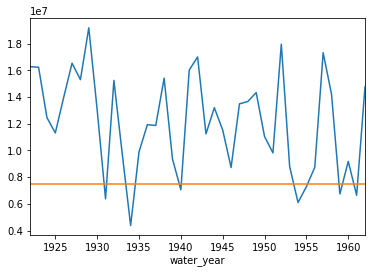

In [24]:
wateryears['Lees Ferry']['Q_af','sum'].loc[wateryears['Lees Ferry'].index<1963].plot()
plt.plot([1922,1963],[7.5e6,7.5e6])

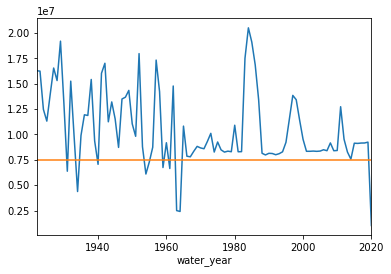

In [25]:
wateryears['Lees Ferry']['Q_af','sum'].loc[wateryears['Lees Ferry'].index].plot()
plt.plot([1922,wateryears['Lees Ferry'].index.max()],[7.5e6,7.5e6])

## Let's do some more exploration of the flow over all record

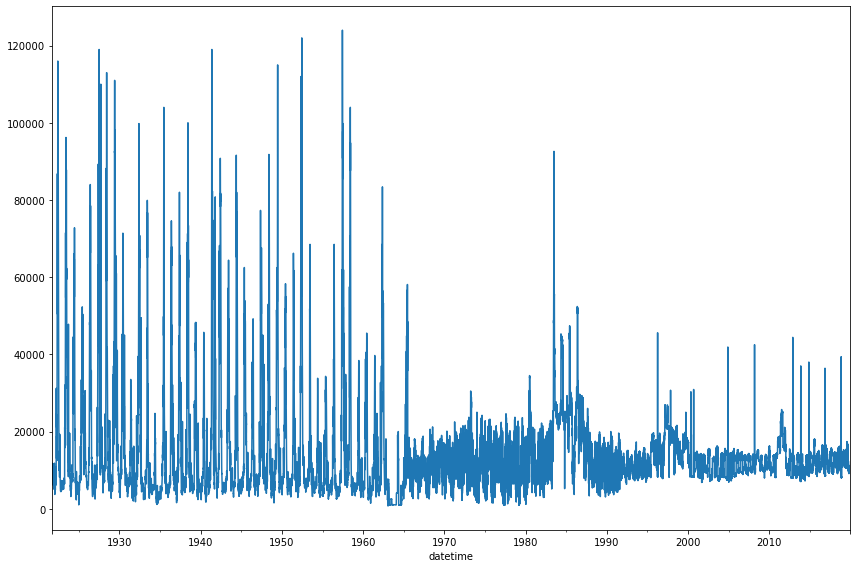

In [26]:
plt.figure(figsize=(12,8))
df_dict['Lees Ferry'].Q.plot()
plt.tight_layout()
plt.savefig('LeesFerryOnePlot.pdf')

## aggregate by group

In [27]:
nwis_df = df_dict['Lees Ferry'].copy()

### first we can apply functions to `groupby` grouping

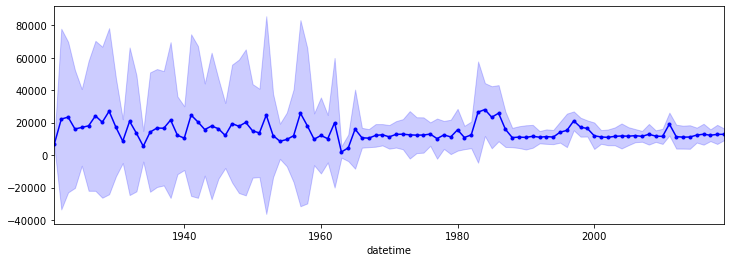

In [28]:
fig = plt.figure(figsize=(12,4))

mean_Q = nwis_df.Q.groupby(nwis_df.index.year).mean()
lower_CI = mean_Q - 2*nwis_df.Q.groupby(nwis_df.index.year).std()
upper_CI = mean_Q + 2*nwis_df.Q.groupby(nwis_df.index.year).std()
ax = mean_Q.plot(style='b.-')
plt.fill_between(lower_CI.index,lower_CI,upper_CI, color='b',alpha = 0.2)

# can accomplish this in one step using `aggregate`

In [29]:
Q_agg = nwis_df.Q.groupby(nwis_df.index.year).aggregate([np.min, np.mean, np.std])

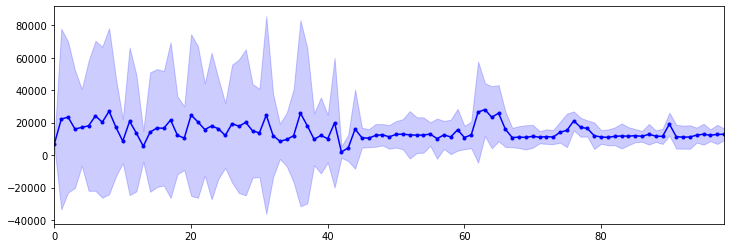

In [30]:
def plot_agg(Q_agg_in):
    Q_agg = Q_agg_in.copy()
    Q_agg.reset_index(drop=True, inplace=True)
    fig = plt.figure(figsize=(12,4))
    lower_CI = Q_agg['mean'] - 2*Q_agg['std']
    upper_CI = Q_agg['mean'] + 2*Q_agg['std']
    ax = Q_agg['mean'].plot(style='b.-')
    plt.fill_between(Q_agg.index,lower_CI,upper_CI, color='b',alpha = 0.2)
plot_agg(Q_agg)

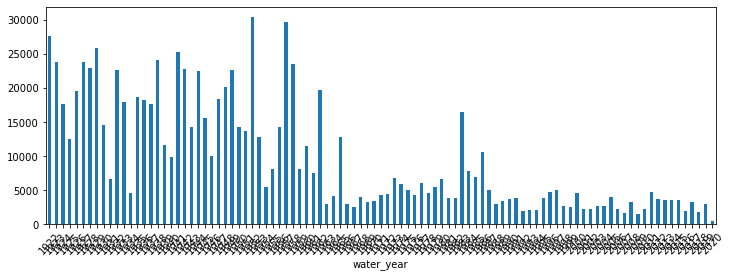

In [31]:
fig = plt.figure(figsize=(12,4))
nwis_df.Q.groupby(nwis_df.water_year).std().plot(kind='bar',rot=45)

### how hard to change from annual aggregation to monthly?

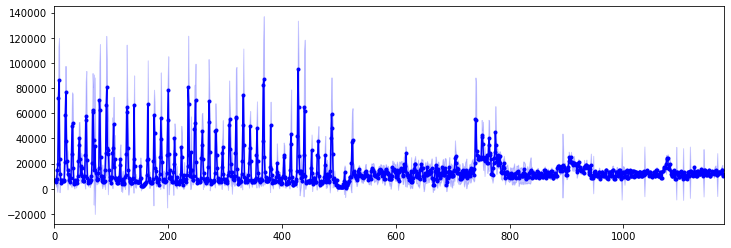

In [32]:
Q_agg_month = nwis_df.Q.groupby([nwis_df.index.year, nwis_df.index.month]).aggregate([np.min, np.mean, np.std])
plot_agg(Q_agg_month)

## navigate

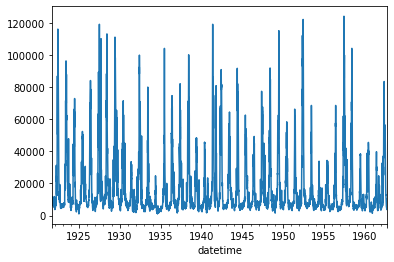

In [33]:
nwis_df.loc[nwis_df.water_year<1963].Q.plot()

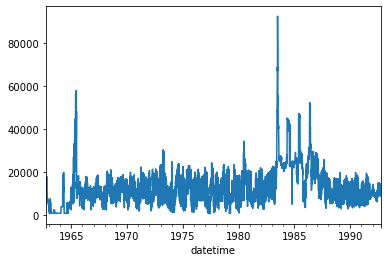

In [34]:
nwis_df.loc[(nwis_df.water_year<1993) & (nwis_df.water_year>=1963)].Q.plot()

## set values

In [35]:
nwis_df = df_dict['Lees Ferry'].copy()
nwis_df.loc[(nwis_df.index.year<1990) & (nwis_df.index.year>1948), 'Q'] *= 10

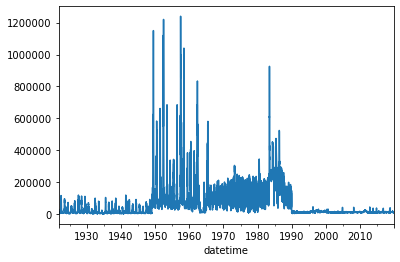

In [36]:
nwis_df.Q.plot()

In [37]:
# set them back
nwis_df.loc[(nwis_df.index.year<1990) & (nwis_df.index.year>1948), 'Q'] /= 10

## groupby

In [43]:
plot_fig=True
if plot_fig:
    with PdfPages(os.path.join('data','allyears_LeesFerry.pdf')) as outpdf:
        for cname,cgroup in nwis_df.groupby(nwis_df.index.year):
            print(cname)
            plt.figure()
            cgroup.Q.plot(title=cname)
            plt.ylabel('cfs')
            plt.xlabel('date')
            plt.tight_layout()
            plt.ylim([0, nwis_df.Q.max()])
            outpdf.savefig()
            plt.close('all')


1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


## now let's look at Lees Ferry and the Grand Canyon together

## we checked out the Lees Ferry record and found no gaps, but what about Grand Canyon?

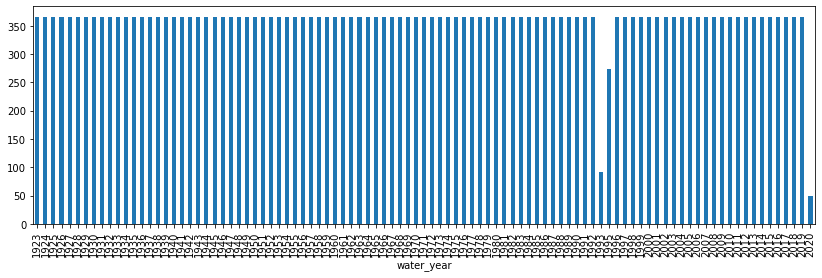

In [38]:
# Note this has a multiple inbdex
plt.figure(figsize=(14,4))
wateryears['Grand Canyon']['Q','count'].plot(kind='bar')


## crumbs... looks like some year in the 1990s is short some data

In [39]:
wateryears['Grand Canyon'].loc[wateryears['Grand Canyon'].index<2018].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   94.000000     94.000000  9.400000e+01   94.000000  9.400000e+01   
mean   361.372340  15121.056962  5.479037e+06  361.372340  1.306459e+09   
std     29.719833   5027.104719  1.894034e+06   29.719833  4.343418e+08   
min     91.000000   3756.038251  9.336100e+05   91.000000  3.245217e+08   
25%    365.000000  11995.415132  4.361532e+06  365.000000  1.036404e+09   
50%    365.000000  13237.105846  4.820890e+06  365.000000  1.143686e+09   
75%    365.750000  18608.621210  6.806120e+06  365.750000  1.607785e+09   
max    366.000000  28593.442623  1.046520e+07  366.000000  2.470473e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.400000e+01   94.000000     94.000000  9.400000e+01  
mean   4.733888e+11  361.372340  29992.247952  1.086754e+07  
std    1.636445e+11   29.719833   9971.139689  3.756770e+06  
min    8.066390e+10   91.000000   7450.010329  1.851793e+06  
25%    3.768364e+11  365.000000  23792.613560  8.650993e+06  
50%    4.165249e+11  365.000000  26255.476829  9.562118e+06  
75%    5.880488e+11  365.750000  36909.746638  1.349977e+07  
max    9.041933e+11  366.000000  56714.396558  2.075747e+07

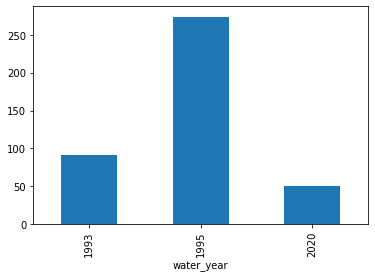

In [40]:
wateryears['Grand Canyon']['Q','count'].loc[wateryears['Grand Canyon']['Q','count']<300].plot(kind='bar')

## so what happens if we try to combine the datasets on a common time index?

## let's work just with 1993-1995, making specific dataframes for now

In [41]:
dfGC = df_dict['Grand Canyon'].copy()
dfLF = df_dict['Lees Ferry'].copy()



## is the GC data less complete?

In [42]:
print(len(dfGC))
print(len(dfLF))

34749
35844


## how does this sort out with `groupby` and `aggregate`?

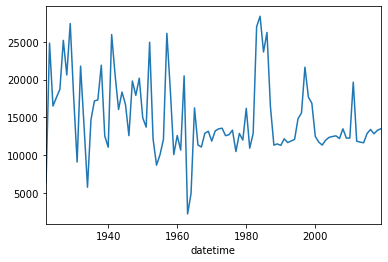

In [43]:
df_GC_agg = dfGC.groupby(dfGC.index.year).aggregate([np.mean,np.std,'count'])
df_GC_agg['Q','mean'].plot()

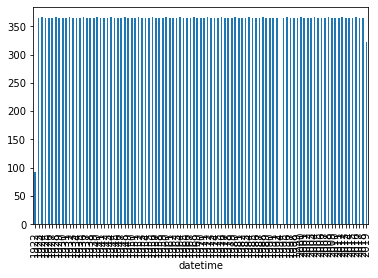

In [44]:
df_GC_agg['Q','count'].plot(kind='bar')

## let's trim down to the years around 1994 to explore how to merge them

In [45]:
dfGC = dfGC.loc[(dfGC.index.year>=1993) & (dfGC.index.year<=1995)]
dfLF = dfLF.loc[(dfLF.index.year>=1993) & (dfLF.index.year<=1995)]

## one easy way is `pd.concat` -- note difference between `inner` and `outer` join

In [46]:
df_combined=pd.concat([dfLF.Q,dfGC.Q],axis=1,join='inner')

df_combined.columns = [['Q_LF', 'Q_GC']]
df_combined.dtypes

Q_LF    int64
Q_GC    int64
dtype: object

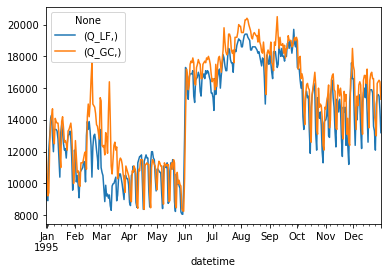

In [47]:
df_combined.plot()

In [48]:
# NOte that the axis controls col vs. row join (axis 0 = rows)
df_combined=pd.concat([dfLF.Q,dfGC.Q],axis=1,join='outer')
df_combined.columns = [['Q_LF', 'Q_GC']]
df_combined.dtypes

Q_LF      int64
Q_GC    float64
dtype: object

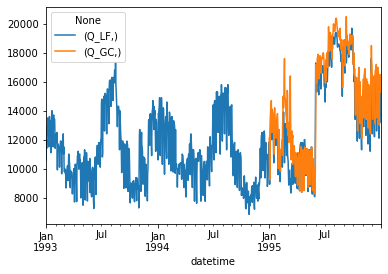

In [49]:
df_combined.plot()

## how can we fill in the missing data?

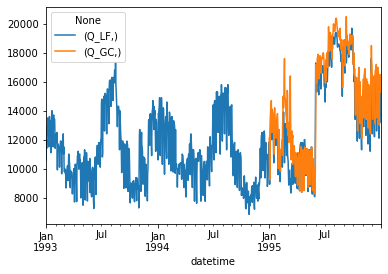

In [50]:
df_ffill=df_combined.fillna(method='ffill')
df_ffill.plot()

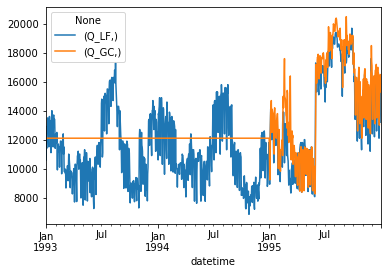

In [51]:
df_bfill=df_combined.fillna(method='bfill')
df_bfill.plot()

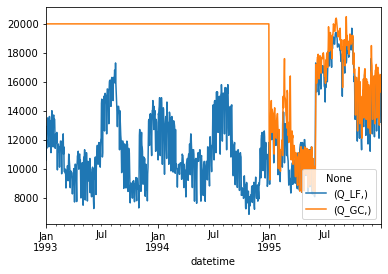

In [52]:
df_val = df_combined.fillna(value=20000)
df_val.plot()

## or we can impute from the other series somehow

## first just drop the NaN values for comparison

In [53]:
df_combined.to_csv('tmp')
df_combined = pd.read_csv('tmp', index_col=0)
df_dropna = df_combined.dropna()

In [54]:
len(df_dropna)

366

In [55]:
df_dropna.head()

,Q_LF,Q_GC
1994-12-31,10600.0,12100.0
1995-01-01,8960.0,10800.0
1995-01-02,8920.0,9220.0
1995-01-03,12100.0,9430.0
1995-01-04,13000.0,12600.0


In [56]:
df_dropna['Qrat'] = df_dropna.Q_GC/df_dropna.Q_LF


C:\Users\votercb\AppData\Local\conda\conda\envs\pyclass\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
df_dropna.head()

,Q_LF,Q_GC,Qrat
1994-12-31,10600.0,12100.0,1.141509
1995-01-01,8960.0,10800.0,1.205357
1995-01-02,8920.0,9220.0,1.033632
1995-01-03,12100.0,9430.0,0.779339
1995-01-04,13000.0,12600.0,0.969231


## ok, let's find the mean ratio and apply that to fill in missing data

In [58]:
mean_rat = df_dropna.Qrat.mean()
mean_rat

1.0599506521201096

In [60]:
# In the past, this was a problem. WHen read in csv, sometimes Na's would be read in as not numeric. But it is now.
df_combined['Q_LF'] = [float(i) for i in df_combined['Q_LF'].values]
df_combined.dtypes

Q_LF    float64
Q_GC    float64
dtype: object

In [61]:
df_combined.Q_GC=df_combined.Q_GC.fillna(df_combined.Q_LF*mean_rat)
        

In [62]:
np.unique(np.isnan(df_combined.Q_GC))

array([False,  True])

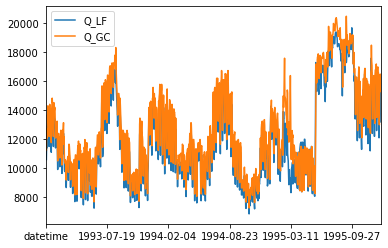

In [63]:
df_combined.plot()

In [64]:
dfGC_monthly = dfGC.resample('M')

In [65]:
dfGC_monthly

In [66]:
dfGC_monthly.mean()

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1994-12-31,12100.000000,1995.0,1.045440e+09,24000.055097
1995-01-31,12691.935484,1995.0,1.096583e+09,25174.144702
1995-02-28,13079.285714,1995.0,1.130050e+09,25942.444443
1995-03-31,11930.322581,1995.0,1.030780e+09,23663.504071
1995-04-30,10452.000000,1995.0,9.030528e+08,20731.287262
1995-05-31,10214.838710,1995.0,8.825621e+08,20260.883623
1995-06-30,17153.333333,1995.0,1.482048e+09,34023.218602
1995-07-31,18306.451613,1995.0,1.581677e+09,36310.400606
1995-08-31,19087.096774,1995.0,1.649125e+09,37858.791257
